In [1]:
import numpy as np
import glob
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import tqdm
import os
from PIL import Image
from IPython import display 

In [2]:
class KalmanFilter2D:
    def __init__(self, dt, process_noise, measurement_noise, initial_state, initial_covariance):
        self.dt = dt
        
        # State vector [x, y, vx, vy]
        self.x = np.array(initial_state)
        
        # State transition matrix
        self.F = np.array([
            [1, 0, dt, 0],
            [0, 1, 0, dt],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])
        
        # Process noise covariance
        self.Q = process_noise * np.array([
            [dt**4/4, 0, dt**3/2, 0],
            [0, dt**4/4, 0, dt**3/2],
            [dt**3/2, 0, dt**2, 0],
            [0, dt**3/2, 0, dt**2]
        ])
        
        # Measurement matrix
        self.H = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0]
        ])
        
        # Measurement noise covariance
        self.R = measurement_noise * np.eye(2)
        
        # State covariance matrix
        self.P = np.array(initial_covariance)
    
    def predict(self):
        # Predict the state
        self.x = np.dot(self.F, self.x)
        
        # Predict the state covariance
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q

    def predict_without_update(self, steps=1):
        x = self.x
        P = self.P
        traj,trajP = [], []

        for _ in range(steps):
            # Predict the state
            x = np.dot(self.F, x)
            
            # Predict the state covariance
            P = np.dot(np.dot(self.F, P), self.F.T) + self.Q

            traj.append(x)
            trajP.append(P)
        return traj, trajP
        
    def update(self, z):
        if not np.isnan(z).any():
            # Measurement residual
            y = z - np.dot(self.H, self.x)
            
            # Residual covariance
            S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
            
            # Kalman gain
            K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
            
            # Update the state
            self.x = self.x + np.dot(K, y)
            
            # Update the state covariance
            self.P = np.dot((np.eye(len(self.x)) - np.dot(K, self.H)), self.P)
    
    def get_state(self):
        return self.x

def EraseTraj(arr, locs):
    arr = np.array(arr)
    for loc in locs:
        arr[loc[0]:loc[1],:] = [None,None]

    return arr

In [66]:
steps = 100 #steps to generate ground truth
horizon = 20 #prediction horizon to generate
T = 70 #steps to 'play' out scenario (<= steps)
A = [[1.5*i,i] for i in range(steps)]
B = [[300-i,200-2*i] for i in range(steps)]
C = [[i,100+0.3*i] for i in range(steps)]
C = EraseTraj(C, [[20,50],[70,80]])

objs = [A,B,C]
objs = np.array(objs)
objs += np.random.normal(0,0.5,objs.shape)

dt = 1.0  # Time step
process_noise = 0  # Process noise variance
measurement_noise = 1e-4  # Measurement noise variance
initial_state = [0, 0, 0, 0]  # Initial state: position (0,0), velocity (1,1)
initial_covariance = np.eye(4)  # Initial state covariance

t_plots = range(T)
kfs = []
for _ in range(len(objs)):
    kfs.append(KalmanFilter2D(dt, process_noise, measurement_noise, initial_state, initial_covariance))

for t in tqdm.tqdm(range(T)):
    for i in range(len(objs)):
        kfs[i].predict()
        kfs[i].update(objs[i][t])
        
    if t+1 in t_plots:
        for obji,obj in enumerate(objs):
            plt.scatter(*(obj[0].T), s=3)
            tx, tP = kfs[obji].predict_without_update(steps=horizon)
            tx = np.array(tx)[:,:2]
            plt.scatter(*tx.T, s=1, label=f'{obji} prediction')

        for obji, obj in enumerate(objs):
            plt.scatter(*obj[:t].T, s=3, label=f'{obji} real')
        plt.xlim(-1,301)
        plt.ylim(-1,201)
        plt.legend()
        plt.title(t)
        
        plt.grid()
        plt.savefig(f'imgs/{t}.jpg')
        plt.clf()

100%|██████████| 70/70 [00:16<00:00,  4.21it/s]


<Figure size 640x480 with 0 Axes>

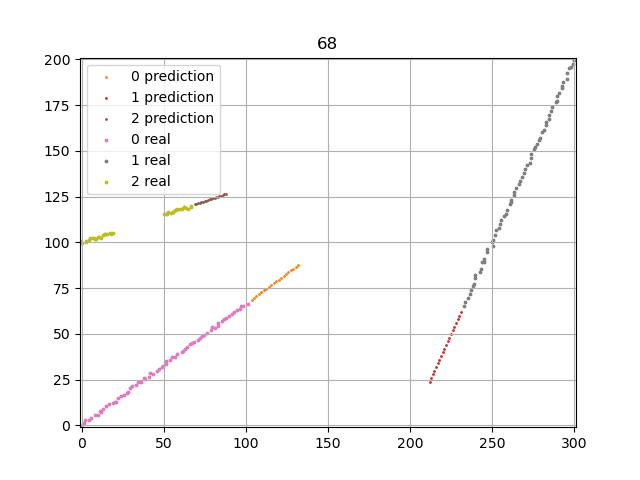

In [9]:
import os
from IPython.display import Image, display, clear_output
import time

# Define the folder where your images are stored
image_folder = 'imgs'

# List all files in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))]
image_files = [int(i.replace('.jpg','')) for i in image_files]
image_files = sorted(image_files)
image_files = [f'{i}.jpg' for i in image_files]

# Set the duration (in seconds) for each image to be displayed
duration = 0.05

# Display each image in the folder
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    display(Image(filename=image_path))
    time.sleep(duration)
    clear_output(wait=True)


C:\Users\MaorKehati\AppData\Local\Temp\ipykernel_2504\3310032556.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(image_path))


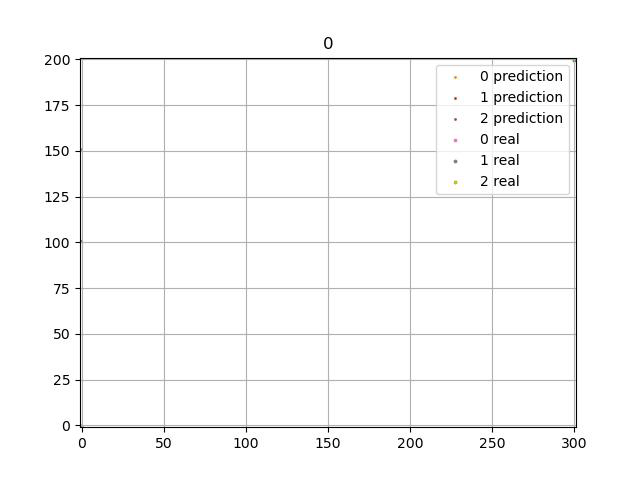

In [68]:
import os
import imageio

# Define the folder where your images are stored
image_folder = 'imgs'

# List all files in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))]
image_files = [int(i.replace('.jpg','')) for i in image_files]
image_files = sorted(image_files)
image_files = [f'{i}.jpg' for i in image_files]

# Define the output path for the GIF
output_gif = 'animation.gif'

# Create a list to store the images
images = []

# Read and append each image to the list
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    images.append(imageio.imread(image_path))

# Save the images as an animated GIF
imageio.mimsave(output_gif, images, duration=0.5)

# Display the GIF in the notebook
from IPython.display import Image, display
display(Image(filename=output_gif))
